In [4]:
# Load necessary libraries
# This section loads all the required libraries for the script.
library(argparse)  
library(Seurat)    
library(scales)    
library(patchwork) 
library(dplyr)     
library(ggtree)    
library(aplot)    
library(reshape2)  
library(RColorBrewer) 
library(ggplot2)  
library(ggsci)     
library(tidyr)     
library(Matrix)    
library(readxl)    
library(data.table)

# Set working directory
# This sets the current working directory to the specified path.
#setwd('/jdfssz3/ST_STOMICS/P22Z10200N0661/lishenglong/test/00.brain/00.Stereo/marmoset1/03.analize/10.assess')

# Function to parse command line arguments
# This function creates an argument parser and defines all the possible command-line arguments.
# It then parses the arguments and returns them as a list.
parse_arguments <- function() {
  parser <- ArgumentParser()
  # Input gem file argument
  parser$add_argument("-g", "--gem", type = "character", default = '',
                      help = "input gem (gem/gem.gz)",
                      metavar = "xxx.gem")
  # Function to create h5ad, rds or all argument
  parser$add_argument("-f", "--func", type = "character", default = 'all',
                      help = "function to create h5ad, rds or all, default all",
                      metavar = "h5ad/rds/all")
  # Output file name argument
  parser$add_argument("-o", "--output", type = "character", default = '',
                      help = "output file name",
                      metavar = "output")
  # Sample name argument
  parser$add_argument("-s", "--sample", type = "character", default = 'sample',
                      help = "sample name",
                      metavar = "sample")
  # Gem columns names argument
  parser$add_argument("-C", "--columns", type = "character", default = c('geneID', 'x', 'y', 'MIDCount', 'cell', 'region'), nargs = '+',
                      help = "set the gem columns names, must include(geneID x y MIDCount) default: geneID x y MIDCount cell region",
                      metavar = "geneID x y MIDCount cell region")
  # Bin size argument
  parser$add_argument("-b", "--bin", type = "character", default = '50',
                      help = "input cell or bin(10/20/50/100/200/...), if you choose cellbin, your columns must include cell, default 50",
                      metavar = "(10/20/50/100/200/...)/cell")
  # Region columns names argument
  parser$add_argument("-r", "--regions", type = "character", default = c('region'), nargs = '+',
                      help = "the columns name of region, default region",
                      metavar = "region1 region2 ...")
  # Regions not to be used argument
  parser$add_argument("-n", "--none", type = "integer", default = c(), nargs = '+',
                      help = "regions don't used",
                      metavar = "0 1 2 3 ...")
  # Coordinate columns names argument
  parser$add_argument("-c", "--coordinate", type = "character", default = c('x', 'y'), nargs = '+',
                      help = "the columns name of coordinate,must include(x y), default: x y",
                      metavar = "x y rx ry ...")
  # Cluster rds using Seurat argument
  parser$add_argument("--cluster", action = 'store_true', default = FALSE,
                      help = "cluster rds use seurat")
  # Normalize before clustering argument
  parser$add_argument("--normalize", action = 'store_true', default = FALSE,
                      help = "normalize before cluster")
  # Region annotation file argument
  parser$add_argument("-a", "--anno", type = "character", default = FALSE,
                      help = "region annotation file")
  return(parser$parse_args())
}

# Function to calculate bin size
# This function calculates the bin size based on the input data frame and slice name.
# It first filters the data for non-zero cell labels, groups by cell, and calculates the average diameter.
# Finally, it returns the mean diameter as the bin size.
calculate_bin_size <- function(df_list, slice) {
  
  # Filter data for non-zero cell labels
  dia <- df_list[df_list$cell_label != "0", ]
  # Create a unique cell identifier
  dia$cell <- paste0(dia$slice, "_", dia$cell_label)
  
  # Group by cell and calculate the average diameter
  dia <- dia %>%
    group_by(cell) %>%
    mutate(d = ((max(x) - min(x)) + (max(y) - min(y))) / 2)
  
  # Select relevant columns and remove duplicates
  d <- dia[, c("cell", "d")]
  d <- d[!duplicated(d), ]
  d <- as.data.frame(d)
  # Calculate the mean bin size
  bin <- mean(d$d)
  # Print the slice name and bin size
  print(paste0(slice, ":", bin))
  return(bin)
}

# Function to process bin data
# This function processes the bin data by calculating the gene count per cell and the cumulative probability.
# It then writes the results to a text file and returns the processed data frame.
process_bin_data <- function(df_list, slice, bin) {
  # Print a message indicating the start of bin data processing
  print("bin10")
  # Select relevant columns
  bin10 <- df_list[, c("gene", "x", "y", "slice")]
  # Convert x and y to numeric type
  bin10$x <- as.numeric(bin10$x)
  bin10$y <- as.numeric(bin10$y)
  
  # Round x and y coordinates based on the bin size
  bin10$x <- round(bin10$x / bin, 0)
  bin10$y <- round(bin10$y / bin, 0)
  # Create a unique cell identifier
  bin10$cell <- paste0(bin10$slice, "_", bin10$x, "_", bin10$y)
  
  # Select relevant columns
  bin10 <- bin10[, c("gene", "cell")]
  # Group by cell and calculate the gene count
  bin10 <- bin10 %>%
    group_by(cell) %>%
    mutate(gene_count = length(gene))
  
  # Select relevant columns and remove duplicates
  bin10 <- bin10[, c("cell", "gene_count")]
  bin10 <- as.data.frame(bin10)
  bin10 <- bin10[!duplicated(bin10), ]
  
  # Calculate the cumulative probability of gene counts
  bin10 <- cumsum(table(bin10$gene_count) / sum(table(bin10$gene_count)))
  bin10 <- data.frame(genes = c("0", names(bin10)), cumulative_prob = c(0, bin10))
  # Set the rowname of the first row to 0
  rownames(bin10)[1] <- 0
  
  # Check if the 'bin' folder exists, if not, create it
  bin_folder <- "bin"
  if (!dir.exists(bin_folder)) {
    dir.create(bin_folder)
  }
  
  # Write the results to a text file
  write.table(bin10, paste0("bin/", slice, ".txt"), quote = F)
  return(bin10)
}

# Function to process background data
# This function processes the background data by calculating the unique gene count per cell and the cumulative probability.
# It then writes the results to a text file and returns the processed data frame.
process_background_data <- function(df_list, slice, bin) {
  # Print a message indicating the start of background data processing
  print("back")
  # Filter data for zero cell labels
  background <- df_list[df_list$cell_label == "0", ]
  # Convert x and y to numeric type
  background$x <- as.numeric(background$x)
  background$y <- as.numeric(background$y)
  
  # Round x and y coordinates based on the bin size
  background$x <- round(background$x / bin, 0)
  background$y <- round(background$y / bin, 0)
  # Create a unique cell identifier
  background$cell <- paste0(background$slice, "_", background$x, "_", background$y)
  
  # Select relevant columns
  background <- background[, c("gene", "cell")]
  # Group by cell and calculate the unique gene count
  background <- background %>%
    group_by(cell) %>%
    mutate(gene_count = length(unique(gene)))
  
  background <- as.data.frame(background)
  # Select relevant columns and remove duplicates
  data <- background[, c('cell', 'gene_count')]
  data <- data[!duplicated(data), ]
  
  # Calculate the cumulative probability of gene counts
  back <- cumsum(table(data$gene_count) / sum(table(data$gene_count)))
  back <- data.frame(genes = c("0", names(back)), cumulative_prob = c(0, back))
  # Set the rowname of the first row to 0
  rownames(back)[1] <- 0
  
  # Check if the 'back' folder exists, if not, create it
  back_folder <- "back"
  if (!dir.exists(back_folder)) {
    dir.create(back_folder)
  }
  
  # Write the results to a text file
  write.table(back, paste0("back/", slice, ".txt"), quote = F)
  return(back)
}

# Function to process cell data
# This function processes the cell data by calculating the unique gene count per cell and the cumulative probability.
# It then writes the results to a text file and returns the processed data frame.
process_cell_data <- function(df_list, slice) {
  # Print a message indicating the start of cell data processing
  print("cell")
  # Filter data for non-zero cell labels
  cell <- df_list[df_list$cell_label != "0", ]
  # Create a unique cell identifier
  cell$cell <- paste0(cell$slice, "_", cell$cell_label)
  # Select relevant columns
  cell <- cell[, c("gene", "cell")]
  
  # Group by cell and calculate the unique gene count
  cell <- cell %>%
    group_by(cell) %>%
    mutate(gene_count = length(unique(gene)))
  
  cell <- as.data.frame(cell)
  # Select relevant columns and remove duplicates
  cell <- cell[, c('cell', 'gene_count')]
  cell <- cell[!duplicated(cell), ]
  
  # Calculate the cumulative probability of gene counts
  cell <- cumsum(table(cell$gene_count) / sum(table(cell$gene_count)))
  cell <- data.frame(genes = c("0", names(cell)), cumulative_prob = c(0, cell))
  # Set the rowname of the first row to 0
  rownames(cell)[1] <- 0
  
  # Check if the 'cell' folder exists, if not, create it
  cell_folder <- "cell"
  if (!dir.exists(cell_folder)) {
    dir.create(cell_folder)
  }
  
  # Write the results to a text file
  write.table(cell, paste0("cell/", slice, ".txt"), quote = F)
  return(cell)
}

# Function to calculate final statistics
# This function calculates the final statistics based on the processed bin, background, and cell data.
# It finds the closest gene counts to the 0.5 cumulative probability for each data set and calculates the ratios.
# Finally, it writes the results to a text file.
calculate_final_statistics <- function(bin10, back, cell, slice) {
  # Find the closest gene count to the 0.5 cumulative probability in bin10 data
  closest_prob <- bin10$cumulative_prob[which.min(abs(bin10$cumulative_prob - 0.5))]
  closest_bin10 <- bin10$genes[bin10$cumulative_prob == closest_prob]
  
  # Find the closest gene count to the 0.5 cumulative probability in background data
  closest_prob <- back$cumulative_prob[which.min(abs(back$cumulative_prob - 0.5))]
  closest_back <- back$genes[back$cumulative_prob == closest_prob]
  
  # Find the closest gene count to the 0.5 cumulative probability in cell data
  closest_prob <- cell$cumulative_prob[which.min(abs(cell$cumulative_prob - 0.5))]
  closest_cell <- cell$genes[cell$cumulative_prob == closest_prob]
  
  # Calculate the ratios
  x <- as.numeric(closest_bin10) / as.numeric(closest_back)
  y <- as.numeric(closest_cell) / as.numeric(closest_bin10)
  
  # Create a data frame with the results
  df1 <- data.frame("silce" = slice, "back" = x, "cell" = y)
  
  # Check if the 'to_box' folder exists, if not, create it
  to_box_folder <- "to_box"
  if (!dir.exists(to_box_folder)) {
    dir.create(to_box_folder)
  }
  
  # Write the results to a text file
  write.table(df1, paste0("to_box/", slice, ".txt"), quote = F)
}

# Main function to run the analysis
# This is the main function that orchestrates the entire analysis.
# It parses the command-line arguments, reads the input data, calculates the bin size,
# processes the bin, background, and cell data, and finally calculates the final statistics.
main <- function() {
  # Parse command-line arguments
  args <- parse_arguments()
  # Read the input gem file
  df_list <- fread(args$gem)
  # Get the output slice name
  slice <- args$output
    
  # Add slice information to the data frame
  df_list$slice <- slice
  df_list <- as.data.frame(df_list)
  # Convert cell_label to character type
  df_list$cell_label <- as.character(df_list$cell_label)
  
  # Calculate the bin size
  bin <- calculate_bin_size(df_list, slice)
  
  # Process the bin data
  bin10 <- process_bin_data(df_list, slice, bin)
  # Process the background data
  back <- process_background_data(df_list, slice, bin)
  # Process the cell data
  cell <- process_cell_data(df_list, slice)
  
  # Calculate the final statistics
  calculate_final_statistics(bin10, back, cell, slice)
}

# Run the main function


In [18]:
args <- list(
  gem = "example.gem",
  func = "all",
  output = "example_slice",
  sample = "example_sample",
  columns = c('gene', 'x', 'y', 'MIDCount', 'cell_label', 'region'),
  bin = "10",
  regions = c('region'),
  none = c(),
  coordinate = c('x', 'y'),
  cluster = FALSE,
  normalize = FALSE,
  anno = FALSE
)

In [16]:
parse_arguments <- function() {
  return(args)
}

In [17]:
main()

[1] "example_slice:85.1"
[1] "bin10"
[1] "back"
[1] "cell"


In [5]:
back = as.data.frame(fread("data/back/T510.txt"))
bin10 = as.data.frame(fread("data/bin/T510.txt"))
cell = as.data.frame(fread("data/cell/T510.txt"))


Warning message in fread("data/back/T510.txt"):
“Detected 2 column names but the data has 3 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/bin/T510.txt"):
“Detected 2 column names but the data has 3 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/cell/T510.txt"):
“Detected 2 column names but the data has 3 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the fi

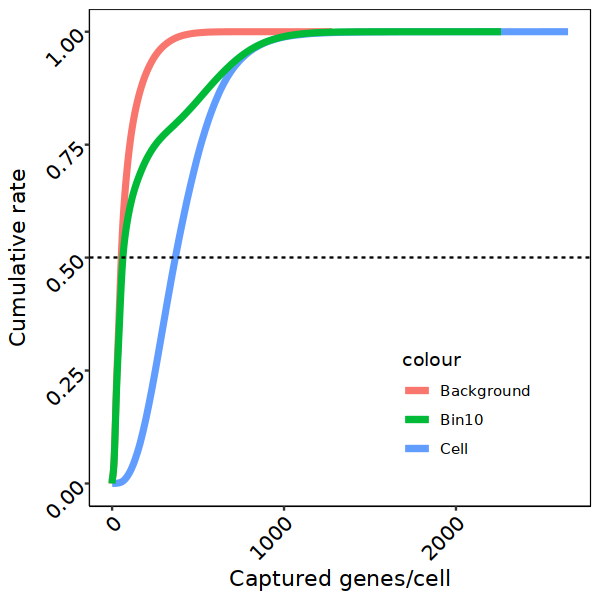

In [8]:
options(repr.plot.width=5,repr.plot.height=5)
ggplot() +
  geom_line(data=back,aes(x = as.numeric(genes),y=cumulative_prob,color = "Background"), linewidth = 1.5) +
  geom_line(data=cell,aes(x = as.numeric(genes),y=cumulative_prob,color = "Cell"), linewidth = 1.5)+
   geom_line(data=bin10,aes(x = as.numeric(genes),y=cumulative_prob,color = "Bin10"), linewidth = 1.5)+
  #geom_smooth(method = "loess", color = "red", se = FALSE) +
  #scale_color_manual(values = c('#501d8a','#1c8041','#e55709'))+
  geom_hline(yintercept = 0.5, linetype = "dashed") +
  labs(x = "Captured genes/cell", y = "Cumulative rate") +
  theme_minimal()+theme_classic()+
  theme(panel.background=element_rect(fill="white",colour="black",size=0.25),

  axis.line= element_line(colour="black",size=0.25),

  axis.title=element_text(size=13,color="black"), 

  axis.text = element_text(size=12,color="black",angle = 45,hjust = 1),
  legend.position= c(0.75,0.2) )#+ggtitle(unique(test$slice))